In [1]:
from graphs_functions import *
from functionality_2 import *
from general_functions import *
from test_data import *

  0%|          | 0/1000 [00:00<?, ?it/s]

## 1. Data


```python
#Answers to questions
a2q = pd.read_csv("data/sx-stackoverflow-a2q.txt", sep=" " ,header=None, names=["user_a", "user_b", "time"], parse_dates=["time"], date_parser=dateparse)

#Comments to answers
c2a = pd.read_csv("data/sx-stackoverflow-c2a.txt", sep=" " ,header=None, names=["user_a", "user_b", "time"], parse_dates=["time"], date_parser=dateparse)

#Comments to questions
c2q = pd.read_csv("data/sx-stackoverflow-c2q.txt", sep=" " ,header=None, names=["user_a", "user_b", "time"], parse_dates=["time"], date_parser=dateparse)


```

```python
a2q.to_csv("data/a2q.csv", index=False)
c2q.to_csv("data/c2q.csv", index=False)
c2a.to_csv("data/c2a.csv", index=False)
```

In [15]:
test = GRAPH()

n1 = NODE(1)
n2 = NODE(2)
n3 = NODE(3)
n4 = NODE(4)
n5 = NODE(5)
n6 = NODE(6)

test.add_edge(from_n=n1,to_n=n2, time="438", w=57)
test.add_edge(from_n=n1,to_n=n3, time="438", w=12)
test.add_edge(from_n=n3,to_n=n2, time="438", w=2)
test.add_edge(from_n=n2,to_n=n4, time="438", w=24)
test.add_edge(from_n=n2,to_n=n6, time="438", w=45)
test.add_edge(from_n=n3,to_n=n5, time="438", w=6)
test.add_edge(from_n=n5,to_n=n4, time="438", w=31)

## Functionality 2 - Find the best users!

In [3]:
#g_a2q = read_object("data/g_a2q.pkl")

In [4]:
def PageRank_one_iter(graph, d):
    
    for node in graph.nodes:

        update_pagerank(node, graph, d, len(graph))
        
        

def update_pagerank(node, g, d, n):
    in_neighbors = [edge.from_n for edge in g.nodes[node] if edge.from_n != node.value]
    pagerank_sum = sum((node.pageRank / degreeCentrality(node,g)[0]) for node in in_neighbors)
    random_walk = d / n
    node.pageRank = random_walk + (1-d) * pagerank_sum

In [17]:
PageRank_one_iter(test, 0.85)

In [18]:
[el.pageRank for el in test.nodes]

[0.2916666666666667,
 0.38854166666666673,
 0.3135416666666667,
 0.32080729166666666,
 0.17080729166666667,
 0.31518229166666667]

In [21]:
for _ in tqdm(range(0, 100000)):
    PageRank_one_iter(test, 0.05)

[el.pageRank for el in test.nodes]

  0%|          | 0/100000 [00:00<?, ?it/s]

[0.16666666666666674,
 18.37500000000005,
 1.7500000000000027,
 24.688541666666698,
 8.736458333333356,
 16.791666666666675]

In [22]:
[(el.pageRank, el.value) for el in test.nodes]

[(0.16666666666666674, 1),
 (18.37500000000005, 2),
 (1.7500000000000027, 3),
 (24.688541666666698, 4),
 (8.736458333333356, 6),
 (16.791666666666675, 5)]

  0%|          | 0/6 [00:00<?, ?it/s]

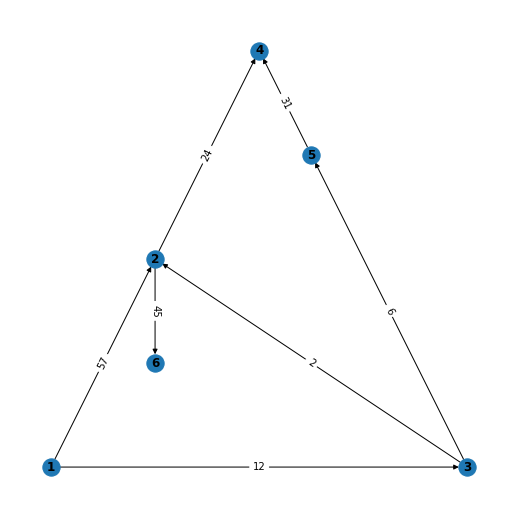

In [8]:
t.print_graph(pos="planar")

6